In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# Load the dataset using pandas
df = pd.DataFrame(X)

# Perform initial EDA
print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nDataset Description:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

Dataset Head:
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.

In [2]:
# Convert 'Date' and 'Time' columns to a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], infer_datetime_format=True)

# Set the datetime column as the index
df.set_index('DateTime', inplace=True)

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Resample the data to a daily frequency, taking the mean of the values
df_daily = numeric_df.resample('D').mean()

# Display the first few rows of the resampled dataset
print("First few rows of the resampled dataset:")
print(df_daily.head())

First few rows of the resampled dataset:
               CO(GT)  PT08.S1(CO)    NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
DateTime                                                                   
2004-03-10   1.966667  1316.500000   86.500000   8.450000     912.333333   
2004-03-11  -6.187500  1244.166667  104.500000   7.979167     851.958333   
2004-03-12 -14.095833  1281.666667  141.500000  12.129167    1008.291667   
2004-03-13  -5.750000  1330.666667  139.250000  10.916667     992.833333   
2004-03-14  -5.966667  1361.125000  116.958333   9.637500     943.916667   

               NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
DateTime                                                                      
2004-03-10  132.000000   1167.333333  108.833333   1545.500000  1096.000000   
2004-03-11  130.041667   1277.250000   87.375000   1522.833333   885.250000   
2004-03-12  142.583333   1101.875000   89.916667   1627.291667  1084.375000   
2004-03-13  168.416667    993.2

C:\Users\User\AppData\Local\Temp\ipykernel_4908\183965367.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], infer_datetime_format=True)


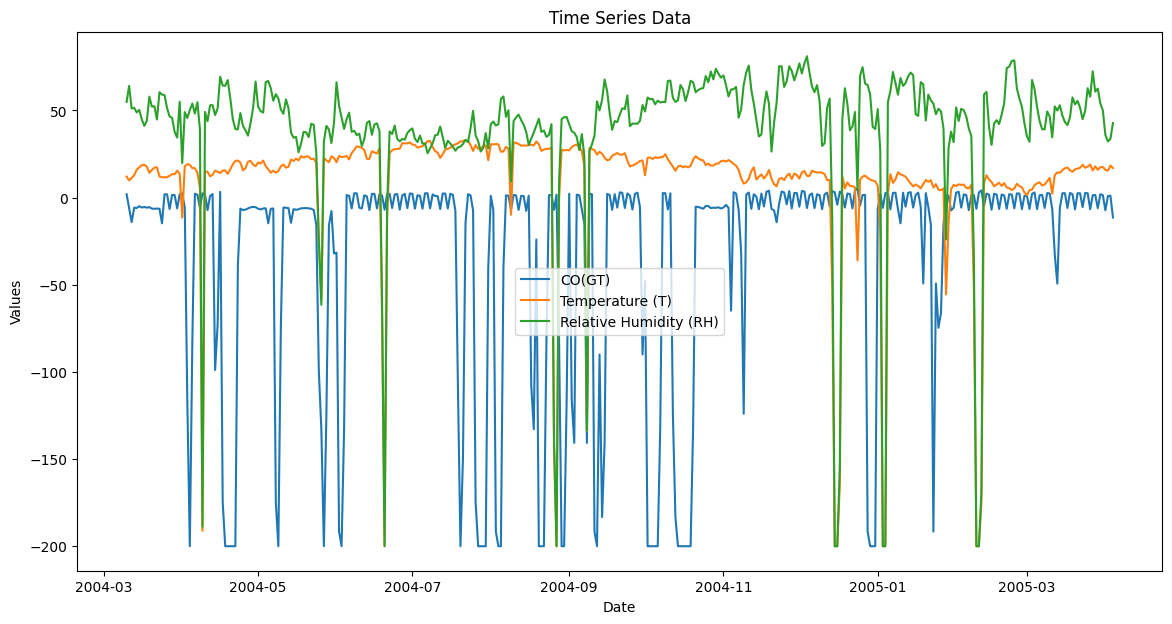

<Figure size 1400x1000 with 0 Axes>

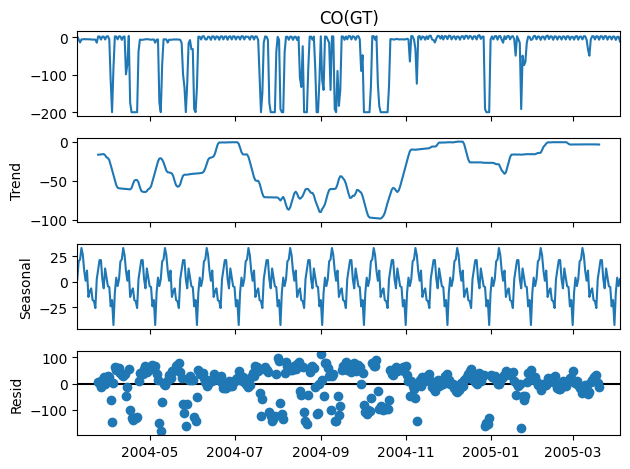

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

# Visualize the time series data using line plots
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['CO(GT)'], label='CO(GT)')
plt.plot(df_daily.index, df_daily['T'], label='Temperature (T)')
plt.plot(df_daily.index, df_daily['RH'], label='Relative Humidity (RH)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Data')
plt.legend()
plt.show()

# Decompose the time series into trend, seasonality, and residuals
result = seasonal_decompose(df_daily['CO(GT)'], model='additive', period=30)

# Plot the decomposed components
plt.figure(figsize=(14, 10))
result.plot()
plt.show()

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# ARIMA Model
# Fit an ARIMA model to the data and determine the appropriate parameters (p, d, q)
arima_model = ARIMA(df_daily['CO(GT)'], order=(5, 1, 0))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

# Forecast using ARIMA
arima_forecast = arima_result.forecast(steps=30)
print("\nARIMA Forecast:")
print(arima_forecast)

# Exponential Smoothing (Holt-Winters method)
hw_model = ExponentialSmoothing(df_daily['CO(GT)'], seasonal='add', seasonal_periods=12)
hw_result = hw_model.fit()
print("\nHolt-Winters Model Summary:")
print(hw_result.summary())

# Forecast using Holt-Winters
hw_forecast = hw_result.forecast(steps=30)
print("\nHolt-Winters Forecast:")
print(hw_forecast)

# Machine Learning Approach (Random Forest)
# Prepare the data
X = df_daily.drop(columns=['CO(GT)'])
y = df_daily['CO(GT)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the Random Forest model
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, rf_predictions)
print("\nRandom Forest Mean Squared Error:", mse)

# Display the predictions
print("\nRandom Forest Predictions:")
print(rf_predictions)

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                 CO(GT)   No. Observations:                  391
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2052.720
Date:                Thu, 28 Nov 2024   AIC                           4117.439
Time:                        17:29:50   BIC                           4141.236
Sample:                    03-10-2004   HQIC                          4126.872
                         - 04-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0354      0.043     -0.819      0.413      -0.120       0.049
ar.L2         -0.2581      0.042     -6.157      0.000      -0.340      -0.176
ar.L3         -0.1033      0.03

ARIMA Model Evaluation:
Mean Absolute Error (MAE): 7.866194365831052
Root Mean Squared Error (RMSE): 11.386092460199624
Mean Absolute Percentage Error (MAPE): nan

Holt-Winters Model Evaluation:
Mean Absolute Error (MAE): 14.961973418519003
Root Mean Squared Error (RMSE): 17.641320135698532
Mean Absolute Percentage Error (MAPE): nan


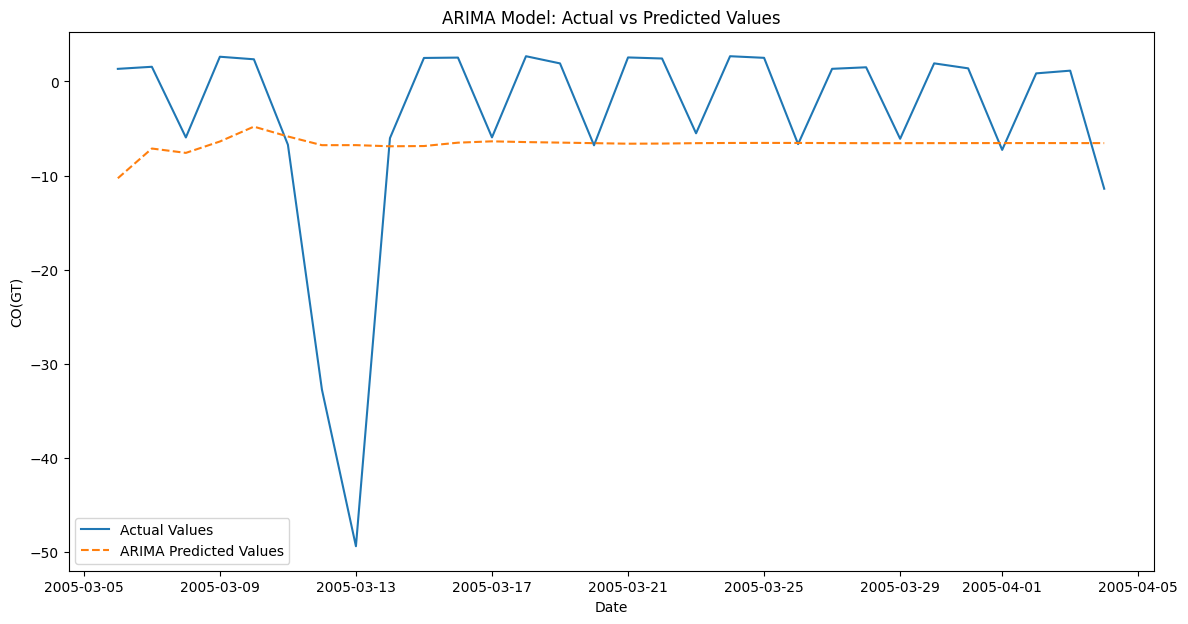

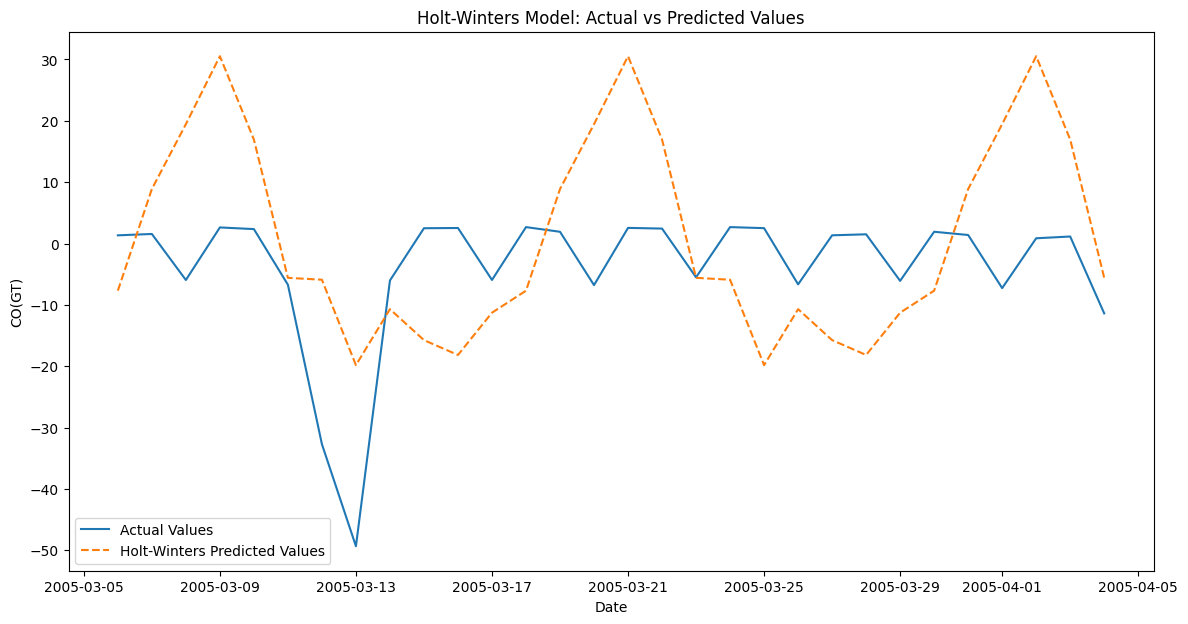

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

import matplotlib.pyplot as plt

# Align the lengths of y_test and the forecasted values
y_test_aligned = y_test[-30:]

# Calculate MAE, RMSE, and MAPE for ARIMA model
arima_mae = mean_absolute_error(y_test_aligned, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(y_test_aligned, arima_forecast))
arima_mape = np.mean(np.abs((y_test_aligned - arima_forecast) / y_test_aligned)) * 100

print("ARIMA Model Evaluation:")
print("Mean Absolute Error (MAE):", arima_mae)
print("Root Mean Squared Error (RMSE):", arima_rmse)
print("Mean Absolute Percentage Error (MAPE):", arima_mape)

# Calculate MAE, RMSE, and MAPE for Holt-Winters model
hw_mae = mean_absolute_error(y_test_aligned, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(y_test_aligned, hw_forecast))
hw_mape = np.mean(np.abs((y_test_aligned - hw_forecast) / y_test_aligned)) * 100

print("\nHolt-Winters Model Evaluation:")
print("Mean Absolute Error (MAE):", hw_mae)
print("Root Mean Squared Error (RMSE):", hw_rmse)
print("Mean Absolute Percentage Error (MAPE):", hw_mape)

# Visualize the predicted vs. actual values for ARIMA model
plt.figure(figsize=(14, 7))
plt.plot(y_test_aligned.index, y_test_aligned, label='Actual Values')
plt.plot(y_test_aligned.index, arima_forecast, label='ARIMA Predicted Values', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CO(GT)')
plt.title('ARIMA Model: Actual vs Predicted Values')
plt.legend()
plt.show()

# Visualize the predicted vs. actual values for Holt-Winters model
plt.figure(figsize=(14, 7))
plt.plot(y_test_aligned.index, y_test_aligned, label='Actual Values')
plt.plot(y_test_aligned.index, hw_forecast, label='Holt-Winters Predicted Values', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CO(GT)')
plt.title('Holt-Winters Model: Actual vs Predicted Values')
plt.legend()
plt.show() 
y_test_aligned = y_test[-30:]